In [1]:
# Make TFGAN models and TF-Slim models discoverable.
import sys
import os
# This is needed since the notebook is stored in the `tensorflow/models/gan` folder.
sys.path.append('..')
sys.path.append(os.path.join('..', 'slim'))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import functools
from six.moves import xrange  # pylint: disable=redefined-builtin

import tensorflow as tf

# Main TFGAN library.
tfgan = tf.contrib.gan

# TFGAN MNIST examples from `tensorflow/models`.
from mnist import data_provider
from mnist import util

# TF-Slim data provider.
from datasets import download_and_convert_mnist

# Shortcuts for later.
queues = tf.contrib.slim.queues
layers = tf.contrib.layers
ds = tf.contrib.distributions
framework = tf.contrib.framework

/Users/Zhaofeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)
  

def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    plt.axis('off')
    plt.imshow(np.squeeze(data_np), cmap='gray')
    plt.show()

def visualize_digits(tensor_to_visualize):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            images_np = sess.run(tensor_to_visualize)
    plt.axis('off')
    plt.imshow(np.squeeze(images_np), cmap='gray')

def evaluate_tfgan_loss(gan_loss, name=None):
    """Evaluate GAN losses. Used to check that the graph is correct.
    
    Args:
        gan_loss: A GANLoss tuple.
        name: Optional. If present, append to debug output.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            gen_loss_np = sess.run(gan_loss.generator_loss)
            dis_loss_np = sess.run(gan_loss.discriminator_loss)
    if name:
        print('%s generator loss: %f' % (name, gen_loss_np))
        print('%s discriminator loss: %f'% (name, dis_loss_np))
    else:
        print('Generator loss: %f' % gen_loss_np)
        print('Discriminator loss: %f'% dis_loss_np)

In [4]:
MNIST_DATA_DIR = '/tmp/mnist-data'

if not tf.gfile.Exists(MNIST_DATA_DIR):
    tf.gfile.MakeDirs(MNIST_DATA_DIR)

download_and_convert_mnist.run(MNIST_DATA_DIR)

>> Downloading 100.1%
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
>> Downloading 113.5%
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
>> Downloading 100.4%
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
>> Downloading 180.4%
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting images from:  /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting labels from:  /tmp/mnist-data/train-labels-idx1-ubyte.gz
>> Converting image 60000/60000Extracting images from:  /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Extracting labels from:  /tmp/mnist-data/t10k-labels-idx1-ubyte.gz
>> Converting image 10000/10000
Finished converting the MNIST dataset!


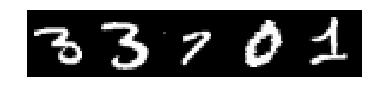

In [21]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    real_images, _, _ = data_provider.provide_data(
        'train', batch_size, MNIST_DATA_DIR)

# Sanity check that we're getting images.
check_real_digits = tfgan.eval.image_reshaper(
    real_images[:5,...], num_cols=5)
visualize_digits(check_real_digits)

In [22]:
def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 256)
        net = tf.reshape(net, [-1, 7, 7, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

In [23]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

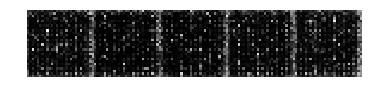

In [24]:
noise_dims = 64
gan_model = tfgan.gan_model(
    generator_fn,
    discriminator_fn,
    real_data=real_images,
    generator_inputs=tf.random_normal([batch_size, noise_dims]))

# Sanity check that generated images before training are garbage.
check_generated_digits = tfgan.eval.image_reshaper(
    gan_model.generated_data[:5,...], num_cols=5)
visualize_digits(check_generated_digits)

In [25]:
# We can use the minimax loss from the original paper.
vanilla_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss)

# We can use the Wasserstein loss (https://arxiv.org/abs/1701.07875) with the 
# gradient penalty from the improved Wasserstein loss paper 
# (https://arxiv.org/abs/1704.00028).
improved_wgan_loss = tfgan.gan_loss(
    gan_model,
    # We make the loss explicit for demonstration, even though the default is 
    # Wasserstein loss.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    gradient_penalty_weight=1.0)

# We can also define custom losses to use with the rest of the TFGAN framework.
def silly_custom_generator_loss(gan_model, add_summaries=False):
    return tf.reduce_mean(gan_model.discriminator_gen_outputs)
def silly_custom_discriminator_loss(gan_model, add_summaries=False):
    return (tf.reduce_mean(gan_model.discriminator_gen_outputs) -
            tf.reduce_mean(gan_model.discriminator_real_outputs))
custom_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=silly_custom_generator_loss,
    discriminator_loss_fn=silly_custom_discriminator_loss)

# Sanity check that we can evaluate our losses.
for gan_loss, name in [(vanilla_gan_loss, 'vanilla loss'), 
                       (improved_wgan_loss, 'improved wgan loss'), 
                       (custom_gan_loss, 'custom loss')]:
    evaluate_tfgan_loss(gan_loss, name)

vanilla loss generator loss: -1.020913
vanilla loss discriminator loss: 1.482391
improved wgan loss generator loss: -0.026264
improved wgan loss discriminator loss: 0.030700
custom loss generator loss: -0.153431
custom loss discriminator loss: 0.113617


In [26]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    gan_model,
    improved_wgan_loss,
    generator_optimizer,
    discriminator_optimizer)

In [27]:
num_images_to_eval = 500
MNIST_CLASSIFIER_FROZEN_GRAPH = './mnist/data/classify_mnist_graph_def.pb'

# For variables to load, use the same variable scope as in the train job.
with tf.variable_scope('Generator', reuse=True):
    eval_images = gan_model.generator_fn(
        tf.random_normal([num_images_to_eval, noise_dims]),
        is_training=False)

# Calculate Inception score.
eval_score = util.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Calculate Frechet Inception distance.
with tf.device('/cpu:0'):
    real_images, _, _ = data_provider.provide_data(
        'train', num_images_to_eval, MNIST_DATA_DIR)
frechet_distance = util.mnist_frechet_distance(
    real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Reshape eval images for viewing.
generated_data_to_visualize = tfgan.eval.image_reshaper(
    eval_images[:5,...], num_cols=5)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Current loss: 0.117179
Current MNIST score: 1.000047
Current Frechet distance: 334.620544
Training step: 0
Time since start: 0.132819 m
Steps per min: 0.000000


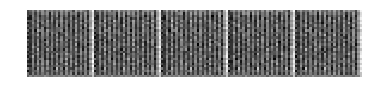

Current loss: -2.717430
Current MNIST score: 1.879578
Current Frechet distance: 210.386856
Training step: 200
Time since start: 2.633540 m
Steps per min: 75.943401


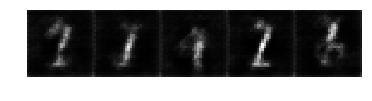

Current loss: -2.979302
Current MNIST score: 5.634005
Current Frechet distance: 58.429749
Training step: 400
Time since start: 5.000968 m
Steps per min: 79.984518


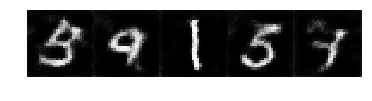

Current loss: -2.110649
Current MNIST score: 5.895665
Current Frechet distance: 60.260258
Training step: 600
Time since start: 7.371918 m
Steps per min: 81.389943


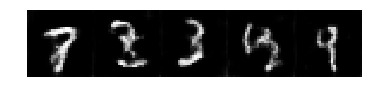

Current loss: -2.265928
Current MNIST score: 6.688160
Current Frechet distance: 51.281586
Training step: 800
Time since start: 9.787810 m
Steps per min: 81.734320


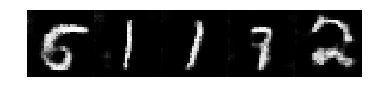

Current loss: -2.121807
Current MNIST score: 7.276356
Current Frechet distance: 36.228069
Training step: 1000
Time since start: 12.198367 m
Steps per min: 81.978185


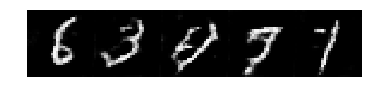

Current loss: -3.008895
Current MNIST score: 7.371636
Current Frechet distance: 28.030998
Training step: 1200
Time since start: 14.605971 m
Steps per min: 82.158179


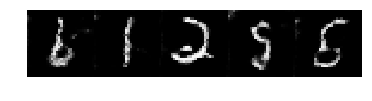

Current loss: -4.482683
Current MNIST score: 7.750454
Current Frechet distance: 36.707901
Training step: 1400
Time since start: 16.962718 m
Steps per min: 82.533942


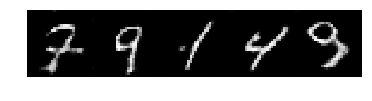

Current loss: -5.317887
Current MNIST score: 8.028731
Current Frechet distance: 13.237458
Training step: 1600
Time since start: 19.338886 m
Steps per min: 82.734858


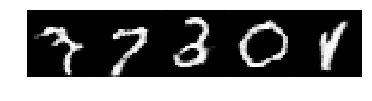

In [29]:
train_step_fn = tfgan.get_sequential_train_steps()

global_step = tf.train.get_or_create_global_step()
loss_values, mnist_scores, frechet_distances  = [], [], []

with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    for i in xrange(1601):
        cur_loss, _ = train_step_fn(
            sess, gan_train_ops, global_step, train_step_kwargs={})
        loss_values.append((i, cur_loss))
        if i % 200 == 0:
            mnist_score, f_distance, digits_np = sess.run(
                [eval_score, frechet_distance, generated_data_to_visualize])
            mnist_scores.append((i, mnist_score))
            frechet_distances.append((i, f_distance))
            print('Current loss: %f' % cur_loss)
            print('Current MNIST score: %f' % mnist_scores[-1][1])
            print('Current Frechet distance: %f' % frechet_distances[-1][1])
            visualize_training_generator(i, start_time, digits_np)

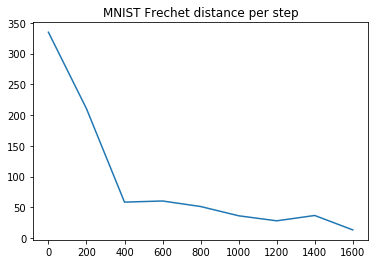

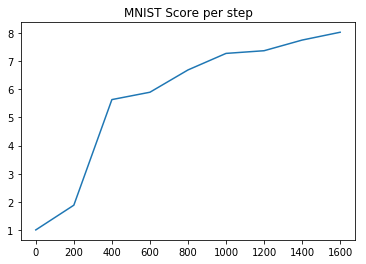

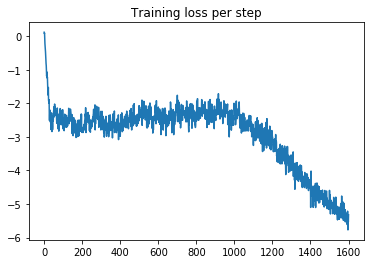

In [30]:
# Plot the eval metrics over time.
plt.title('MNIST Frechet distance per step')
plt.plot(*zip(*frechet_distances))
plt.figure()
plt.title('MNIST Score per step')
plt.plot(*zip(*mnist_scores))
plt.figure()
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))